# MCMC Practice

Below, we are going to practice working with Markov Chain Monte Carlo's (MCMC's). Remember, in a general sense, a MCMC creates samples from the posterior distribution by reversing a standard Markov Chain that has its *equilibrium distribution* as its *target posterior distribution*.

## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import eda
from scipy.stats import norm

plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
% load_ext giphy_magic

In [2]:
wnv = pd.read_csv('NEW_BNum_beat_the_benchmark_unbalanced_XGB.csv')
eda.eda(wnv)
y = wnv.WnvPresent
y.shape

missing values 
WnvPresent    0
Id            0
dtype: int64
dataframe index 
RangeIndex(start=0, stop=116293, step=1)
dataframe types 
WnvPresent    float64
Id              int64
dtype: object
dataframe shape 
(116293, 2)
dataframe describe 
          WnvPresent             Id
count  116293.000000  116293.000000
mean        0.021121   58147.000000
std         0.050339   33571.041765
min         0.000003       1.000000
25%         0.000646   29074.000000
50%         0.005026   58147.000000
75%         0.019825   87220.000000
max         0.867572  116293.000000
WnvPresent
52990
Id
116293


(116293,)

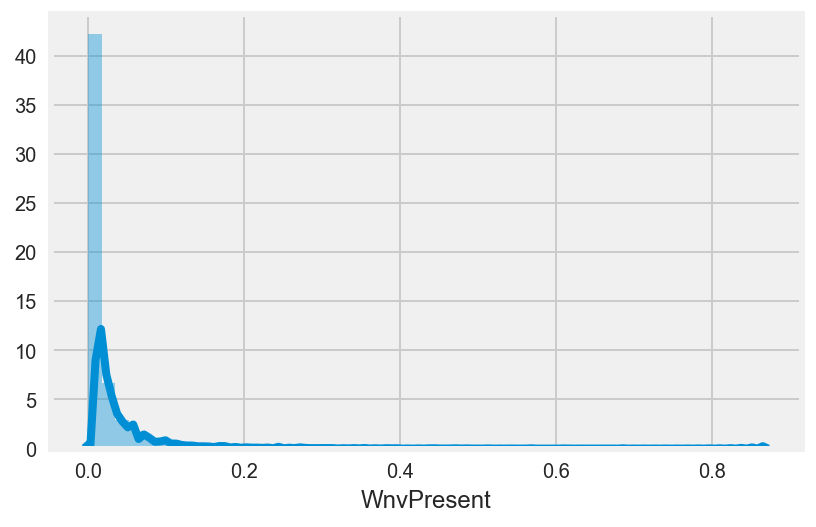

In [3]:
# plot probability distrabution on histogram

sns.distplot(y)

In [9]:
# Not knowing really much my guess is the probility mean will be around 0.05

pred_belief_mean = 0.001
pred_belief_std = 0.02

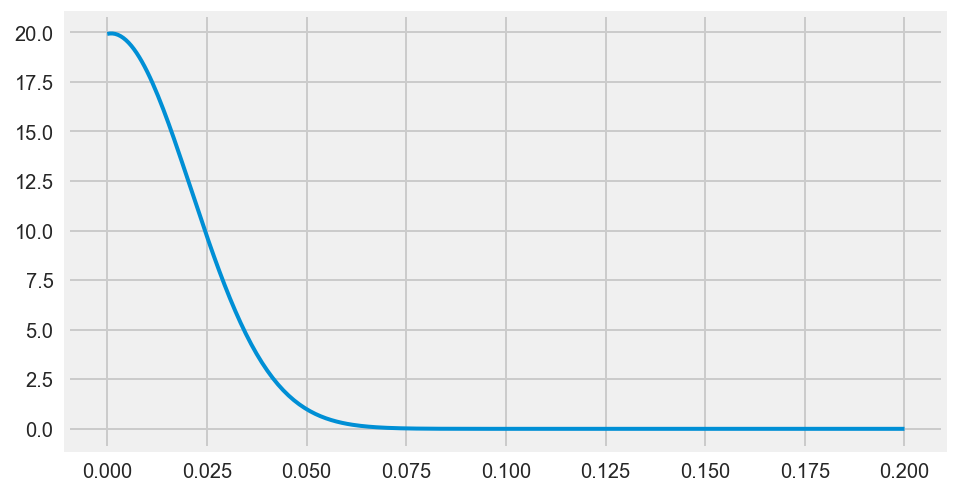

In [10]:
# Chose my Prior based off my guess for the mean
# I am assuming my prior will follow a normal distribution


fig, ax = plt.subplots(figsize=(7,4))
pred_range = np.linspace(0, 0.2, 300)

prior = stats.norm(pred_belief_mean, pred_belief_std) 
pred_pdfs = prior.pdf(pred_range)

ax.plot(pred_range, pred_pdfs, lw=2)
plt.show()

In [11]:
#Define likelihood prior, P(current mean), for my proposed mean

def likelihood_prior(proposed_mean, prior_belief_mean, prior_belief_std):
    prior = stats.norm(prior_belief_mean, prior_belief_std)
    proposed_loglike = prior.pdf(proposed_mean)
    return proposed_loglike

def take_log(likelihood):
    log_like = np.sum(np.log(likelihood))
    return log_like

In [12]:
prior = likelihood_prior(0.01, pred_belief_mean, pred_belief_std )
prior

18.026348123082396

In [13]:
log_prior = take_log(prior)
log_prior

2.8918344722234735

In [14]:
# Plot likelihood prior normal distribution and where the proposed mean will allign with my prior dist.

def plot_prior_loglike(proposed_mean, prior_mean, prior_std):
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.gca()
    x_range = np.linspace(0, 0.2, 300)
    
    prior = stats.norm(prior_mean, prior_std)
    prior_pdf = prior.pdf(x_range)
    proposed_likelihood = prior.pdf(proposed_mean)
    proposed_loglike = take_log(likelihood_prior(proposed_mean, prior_mean, prior_std))
    
    ax.plot(x_range, prior_pdf, lw=4)
    ax.scatter(proposed_mean, proposed_likelihood, color='darkred', s=200,
               label='proposed prior LL: '+'{0:.3f}'.format(proposed_loglike))
    
    ax.legend(loc='upper left')
    plt.show()

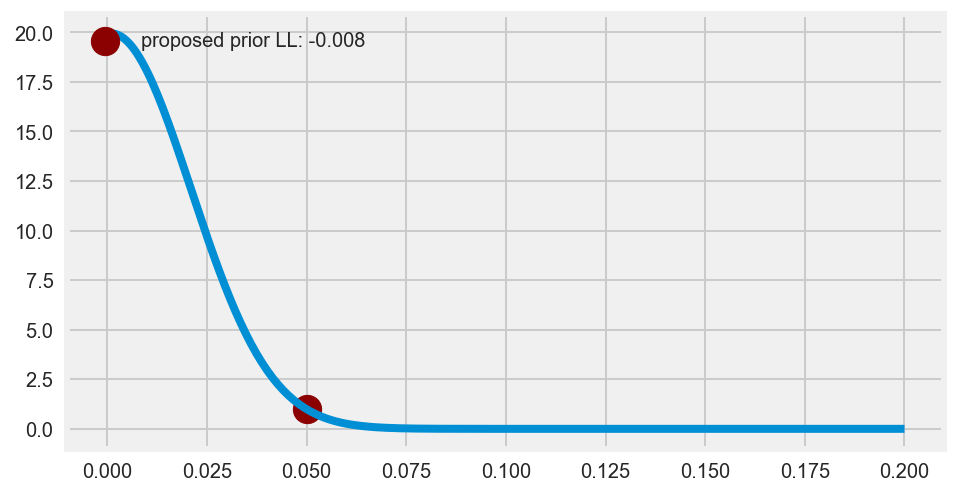

In [16]:
# My random guess higher than my predicted guess lies outside the normal distribtuion

plot_prior_loglike(0.05, pred_belief_mean, pred_belief_std)

In [17]:
# Define function to calculate my predicted likelihood of data

def likelihood_data(data, proposed_mean, proposed_std):
    distribution = stats.norm(proposed_mean, proposed_std) # Set up distribution.
    likelihood = distribution.pdf(data)
    return likelihood


In [18]:
# Define plot function for likelihood of data over actual distribtion

def plot_loglike_data(data, proposed_mean, proposed_std):
    
    # default for plt.subplots is plt.subplots(1, 1)
    # which is 1 row, 1 column, and so its just 1 axis object
    fig = plt.figure(figsize=(7,4))
    ax = fig.gca()
    
    c = sns.distplot(data, bins=40, ax=ax)
    
    proposal_xrange = np.linspace(np.min(data)-0.1, np.max(data)-0.6, 200)
    belief_dist = stats.norm(proposed_mean, proposed_std)
    proposal_pdf = belief_dist.pdf(proposal_xrange)
    
    like = likelihood_data(data, proposed_mean, proposed_std)
    log_like = take_log(like)
    
    a = ax.plot(proposal_xrange, proposal_pdf, lw=4, color='darkgreen', alpha=0.4,
            label='like: '+'{0:.3}'.format(like))
    
    b = ax.plot(proposal_xrange, proposal_pdf, lw=4, color='darkred', alpha=0.4,
            label='log like: '+'{0:.3}'.format(log_like))
    
    ax.legend(loc='upper left')
    plt.show()

In [19]:
likelihood = likelihood_data(y, pred_belief_mean, pred_belief_std)
like = np.sum(likelihood)
like

1786063.6474977378

In [20]:
take_log(likelihood)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


-inf

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


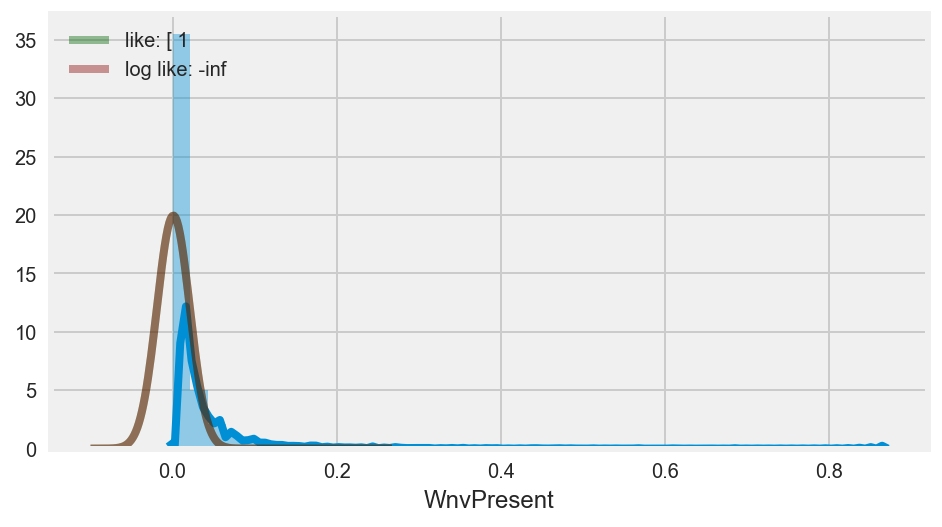

In [21]:
# Already it does not look like we are too far off. But it might not be as normally distrubted as originally anticipated

plot_loglike_data(y, pred_belief_mean, pred_belief_std)

## Step V: Create your MCMC

In [22]:
# Define new proposed mean based off Metropolis Sampler algorithm based off MCMC

def get_new_proposal(proposal_distribution_mean, proposal_distribution_std):
    proposal_distribution = stats.norm(proposal_distribution_mean, proposal_distribution_std)
    new_proposed_statistic = proposal_distribution.rvs()
    return new_proposed_statistic

In [23]:
# Use defined functions above to go through each step of the Metropolis Sampler to return either a new mean
# or keep the old one. 

def metropolis_sampler(data, current_mean, prior_mean, prior_std):
    # 1. figure out P(data|current_mean) --> likelihood of data
    current_data_loglike = take_log(likelihood_data(data, current_mean, prior_std))
    # 2. figure out P(current_mean) on prior distribution
    current_prior_loglike = take_log(likelihood_prior(current_mean, prior_mean, prior_std))
    # 3. combine this into the likelihood of the current mean
    current_loglike = (current_data_loglike + current_prior_loglike)
    
    # 4. get a proposal for a new mean to consider:
    proposed_mean = get_new_proposal(current_mean, 0.001)
    
    # 5. P(data|proposed_mean) 
    proposed_data_loglike = take_log(likelihood_data(data, proposed_mean, prior_std))
    # 6. P(proposed_mean) on prior distribution
    proposed_prior_loglike = take_log(likelihood_prior(proposed_mean, prior_mean, prior_std))
    # 7. combine into proposed likelihood
    proposed_loglike = (proposed_data_loglike + proposed_prior_loglike)
    
    # 8. LL(proposed) / LL(current)
    # this will be from 0 to inf.
    acceptance_criterion = np.exp(proposed_loglike - current_loglike)
    
    # 9. get a random number between 0 and 1
    random_fraction = np.random.rand()
    
    # 10. accept if over random_fraction
    if acceptance_criterion > random_fraction:
        return proposed_mean
    else:
        return current_mean

In [24]:
# Loop through new means in mcmc to get Bayesian Distribution of likely mean

def mcmc(data, initial_proposal, prior_mean, prior_std, iterations=1000):
    
    # 1. keep track of the accepted means:
    accepted_means = [initial_proposal]
    current_mean = initial_proposal
    
    for i in range(iterations):
        if (i % 250) == 0:
            print 'Iteration:', i
        
        current_mean = (metropolis_sampler(data, current_mean, prior_mean, prior_std))
        accepted_means.append(current_mean)
        
    return accepted_means

In [29]:
posterior = (mcmc(y, 0.5, pred_belief_mean, pred_belief_std, iterations=2000))

Iteration: 0


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Iteration: 1250
Iteration: 1500
Iteration: 1750


In [30]:
posterior = [i/11. for i in posterior]

In [31]:
z = y[y < 0.2]

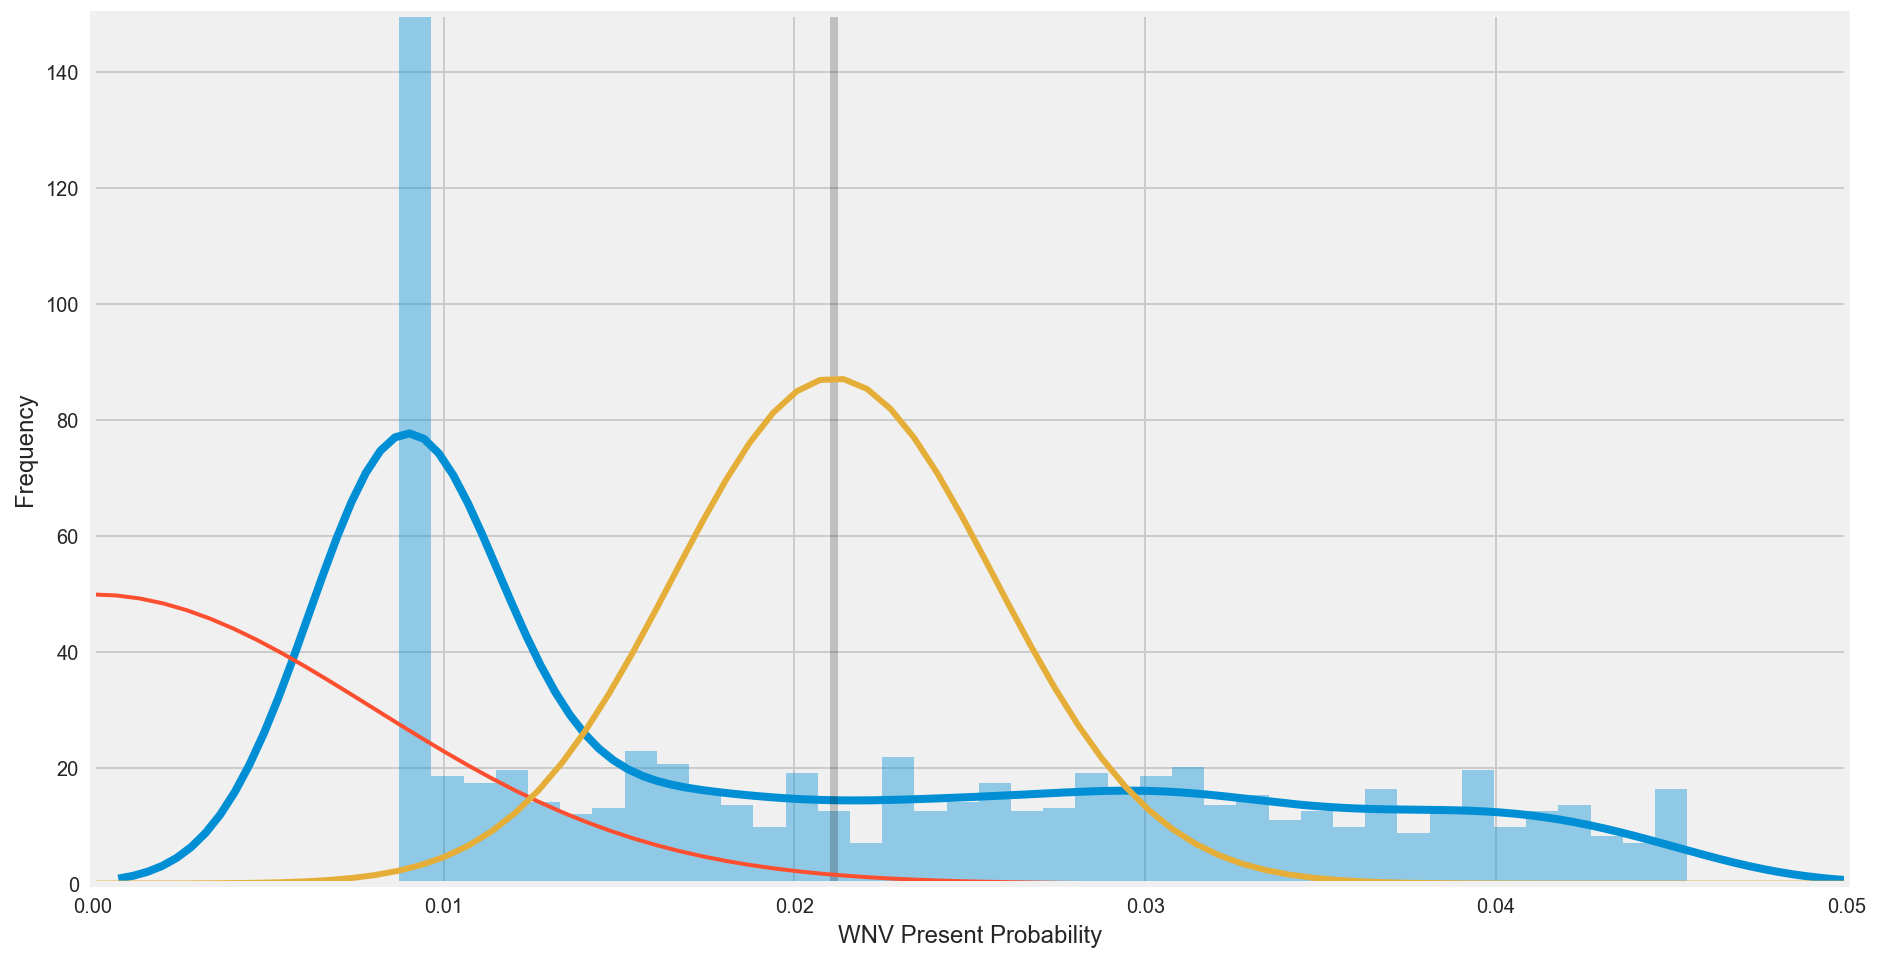

In [34]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.distplot(posterior, bins=40, kde=True)
ax.set(xlabel='WNV Present Probability', ylabel='Frequency')
pred_range = np.linspace(0, 0.2, 300)

prior = stats.norm(np.mean(y), np.std(y)/11.) 
pred_pdfs = prior.pdf(pred_range)
prior_prior = stats.norm(0., pred_belief_std/2.5) 
pred_pdfs_prior = prior_prior.pdf(pred_range)

plt.xlim(0., 0.05)
plt.ylim(0, 150)


plt.axvline(x=0.0211205645526, alpha=0.2, color='black')
0.0315196317286

ax.plot(pred_range, pred_pdfs_prior, lw=2)
ax.plot(pred_range, pred_pdfs, lw=3)
plt.show()

In [37]:
print np.mean(posterior), np.mean(y)
print np.std(y)
print stats.norm.interval(0.95, loc=np.mean(posterior), scale=np.std(posterior) / np.sqrt(len(posterior)))

0.0179966139576 0.0211205645526
0.0503388953194
(0.017491726435378215, 0.018501501479902958)
